# Compression & Entropy

- **Created by Andrés Segura Tinoco**  
- **Created on June 28, 2019**

In signal processing, **data compression**, source coding, or bit-rate reduction involves encoding information using fewer bits than the original representation. Compression can be either lossy or lossless. Lossless compression reduces bits by identifying and eliminating statistical redundancy. No information is lost in lossless compression. Lossy compression reduces bits by removing unnecessary or less important information. <a href='#link_one'>[1]</a>

**Entropy** is a measure of unpredictability, so its value is inversely related to the compression capacity of a chain of symbols (e.g. a file). <a href='#link_two'>[2]</a>

A **cellular automaton** (abbrev. CA) is a discrete model studied in computer science, mathematics, physics, complexity science, theoretical biology and microstructure modeling. <a href='#link_three'>[3]</a> <a href='#link_four'>[4]</a>

## 1. Compression with current Entropy

In [1]:
# Load Python libraries
import numpy as np
import math
import timeit
from collections import Counter
from scipy.stats import entropy

In [2]:
# Load Plot libraries
import seaborn as sns
import matplotlib.pyplot as plt

### Huffman Code class

In [3]:
# Class HuffmanCode from scratch
class HuffmanCode:
    
    # Return a Huffman code for an ensemble with distribution p
    def get_code(self, p_symbols):
        
        # Init validation
        n = len(p_symbols)
        if n == 0:
            return dict()
        elif n == 1:
            return dict(zip(p_symbols.keys(), ['1']))
        
        # Ensure probabilities sum to 1
        self._normalize_weights(p_symbols)
        
        # Returns Huffman code
        return self._get_code(p_symbols);
    
    # (Private) Calculate Huffman code
    def _get_code(self, p):
        
        # Base case of only two symbols, assign 0 or 1 arbitrarily
        if len(p) == 2:
            return dict(zip(p.keys(), ['0', '1']))
        
        # Create a new distribution by merging lowest prob pair
        p_prime = p.copy()
        s1, s2 = self._get_lowest_prob_pair(p)
        p1, p2 = p_prime.pop(s1), p_prime.pop(s2)
        p_prime[s1 + s2] = p1 + p2
        
        # Recurse and construct code on new distribution
        code = self._get_code(p_prime)
        symbol = s1 + s2
        s1s2 = code.pop(symbol)
        code[s1], code[s2] = s1s2 + '0', s1s2 + '1'
        
        return code;
    
    # Return pair of symbols from distribution p with lowest probabilities
    def _get_lowest_prob_pair(self, p):
        
        # Ensure there are at least 2 symbols in the dist.
        if len(p) >= 2:
            sorted_p = sorted(p.items(), key=lambda x: x[1])
            return sorted_p[0][0], sorted_p[1][0];
        
        return (None, None);
    
    # Makes sure all weights add up to 1
    def _normalize_weights(self, p_symbols, t_weight=1.0):
        n = sum(p_symbols.values())
        
        if n != t_weight:
            for s in p_symbols:
                p_symbols[s] = p_symbols[s] / n;

# Create Huffman Code instance
hc = HuffmanCode()

In [4]:
# Function - Read file in low level (Bytes)
def get_file_bytes(file_path):
    with open(file_path, 'rb') as f:
        return bytearray(f.read());
    return None

In [5]:
# Function - Return shannon entropy
def entropy_shannon(symbols, base=None):
    value, counts = np.unique(symbols, return_counts=True)
    return entropy(counts, base=base)

In [6]:
# Loading target file
file_path = "../data/text/book-1.txt"
text_byte_list = get_file_bytes(file_path)[:10000]
print(len(text_byte_list), 'Bytes')

10000 Bytes


### Theoretical compression percentage

In [7]:
# Function - Calculates the compression percentage (%)
def calc_compression_percentage(curr_size, new_size, precision = 14):
    return round((curr_size - new_size) / curr_size * 100, precision)

In [8]:
# Calculate entropy of file
actual_entropy = entropy_shannon(text_byte_list, 2)
actual_entropy

5.163591844716373

In [9]:
# Real compression percentage (%)
max_entropy = 8
compress_rate = calc_compression_percentage(max_entropy, actual_entropy)
print(compress_rate, '%')

35.45510194104534 %


### Real compression percentage

In [10]:
# Function - Calculate code frequency
def get_term_freq(term_list):
    term_freq = {}
    terms_count = dict(Counter(term_list))
    
    for key, value in terms_count.items():
        if isinstance(key, int):
            key = chr(key)
        term_freq[key] = value
    
    return term_freq;

# Function - Build the compress file
def create_compress_file(byte_list, code_list):
    compress_list = []
    
    for symbol in byte_list:
        key = chr(symbol)
        new_symbol = code_list[key]
        compress_list.append(new_symbol)
    
    # Return compress file
    return "".join(compress_list)

# Function - Compressing file
def get_compress_file(byte_list):
    
    # Get symbols frequency
    term_freq = get_term_freq(byte_list)
    
    # Normalize term frequency
    n = sum(term_freq.values())
    for term in term_freq:
        term_freq[term] = term_freq[term] / n;
    
    # Get Huffman coding
    h_code = hc.get_code(term_freq)
    
    # Compressing file with Huffman code
    compress_file = create_compress_file(byte_list, h_code)
            
    return compress_file, h_code;

In [11]:
# Compressing initial text file
compress_file, h_code = get_compress_file(text_byte_list)

In [12]:
# Real compression percentage (%)
curr_size = len(text_byte_list)
new_size = len(compress_file) / 8
compress_rate = calc_compression_percentage(curr_size, new_size)
print(compress_rate, '%')

35.08625 %


## 2. Changing Entropy for higher Compression

The assumption is that by lowering (changing) the entropy of a file, it can be compressed more, than with its current entropy.

#### Util Functions: converts byte list to binary string and vice versa

In [13]:
# Convert a byte list to a bits string
def byte_list_to_bit_string(byte_list):
    bit_string = "".join([bin(byte)[2:].zfill(8) for byte in byte_list])
    return bit_string

In [14]:
# Convert a bits string to a byte list
def bit_string_to_byte_list(bit_string):
    byte_list = []
    n = len(bit_string) // 8
    for i in range(n):
        ix_start = i * 8
        ix_end = (i + 1) * 8
        byte = bit_string[ix_start:ix_end]
        byte_list.append(int(byte, 2))
    return byte_list

In [15]:
# Update a string by index
def update_string(s, i, v):
    ns = s[:i] + v + s[i+1:]
    return ns

### Reversible Linear Cellular Automata

In [16]:
# Creates a Reversible Linear Cellular Automata rule
def create_rlca_rule(byte, r = 2):
    rule = {}
    r_size = 2 * r + 1
    bits = bin(byte)[2:].zfill(r_size)
    b_size = len(bits)
    
    for i in range(0, b_size):
        bin_value = bits[(b_size - i - 1)]
        rule[i] = int(bin_value)
    
    return rule

In [17]:
# Get automata cells value
def get_cells_value(automaton, ix, r, n):
    value = 0
    ix_start = max(ix - r, 0)
    ix_end = min(ix + r + 1, n)
    
    for i in range(ix_start, ix_end):
        if i != ix:
            value += int(automaton[i])
    
    return value

In [18]:
# Apply Linear Cellular Automata rule to current automaton
def apply_lca_rule(automaton, rule, n_cell, r, forward):
    start_time = timeit.default_timer()
    new_automaton = []
    curr_bit_string = (automaton + '.')[:-1]
    
    if forward:
        curr_range = range(0, n_cell, 1)
    else:
        curr_range = range(n_cell - 1, -1, -1)
    
    for i in curr_range:
        gen_ix = get_cells_value(curr_bit_string, i, r, n_cell)
        cell = rule[gen_ix]
        new_cell = str(int(not(int(curr_bit_string[i]) ^ cell)))
        
        if new_cell != curr_bit_string[i]:
            curr_bit_string = update_string(curr_bit_string, i, new_cell)
    
    # Code new automaton and return it
    new_automaton = bit_string_to_byte_list(curr_bit_string)
    return new_automaton

In [19]:
# Restoring entropy process
def restore_entropy(byte_list, key, r, forward=False):
    bit_string = byte_list_to_bit_string(byte_list)
    byte_list = apply_lca_rule(bit_string, key, len(bit_string), r, forward)
    return byte_list

### Test Example of RLCA

In [20]:
# Step 1 - Create a RLCA rule
r = 3
key = create_rlca_rule(19, r)
key

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0}

In [21]:
# Step 2 - Have a byte array
a = list(np.random.randint(0, 256, 50))
print(a)

[150, 195, 12, 87, 31, 241, 191, 168, 173, 47, 248, 252, 193, 192, 243, 6, 93, 52, 186, 170, 127, 119, 217, 84, 223, 221, 65, 136, 89, 162, 149, 160, 209, 241, 138, 121, 47, 89, 48, 162, 141, 212, 59, 81, 106, 24, 146, 11, 24, 145, 179, 39, 153, 133, 219]


In [22]:
# Step 3 - Apply rule in forward way over a
b = restore_entropy(a, key, r, True)
print(b)

[209, 126, 199, 236, 230, 62, 206, 86, 90, 128, 31, 35, 4, 66, 204, 25, 234, 134, 229, 85, 157, 216, 38, 42, 50, 34, 134, 119, 141, 89, 75, 67, 206, 63, 101, 166, 129, 250, 150, 112, 194, 41, 218, 173, 20, 206, 109, 197, 142, 107, 255, 90, 102, 8, 37]


In [23]:
# Step 4 - Apply rule in backward way over b
c = restore_entropy(b, key, r, False)
print(c)

[150, 195, 12, 87, 31, 241, 191, 168, 173, 47, 248, 252, 193, 192, 243, 6, 93, 52, 186, 170, 127, 119, 217, 84, 223, 221, 65, 136, 89, 162, 149, 160, 209, 241, 138, 121, 47, 89, 48, 162, 141, 212, 59, 81, 106, 24, 146, 11, 24, 145, 179, 39, 153, 133, 219]


In [24]:
# Step 5 - Compare initial state vs final state
a == c

True

### Real Example of RLCA

A greedy approach with lossless compression reduces bits will be used. Below, the functions that allow you to find the best entropy configuration for a binary file using the RLCA.

In [25]:
# Function - Find the low entropy setup for target file
def find_low_entropy(byte_list, r, verbose = False):
    start_time = timeit.default_timer()
    
    # Local variables
    B = max(256, pow(2, 2 * r + 1))
    bit_string = byte_list_to_bit_string(byte_list)
    n_cell = len(bit_string)
    best_entropy = 8
    best_key = -1
    best_byte_list = []
    best_bit_string = ''
    
    if verbose:
        print('key size:', B)
        print('neighborhood:', r)
        print('file size:', len(byte_list), 'bytes')
        print('file size:', n_cell, 'bits')
        print('initial entropy:', best_entropy)
    
    for curr_key in range(0, B):
        
        # Create a rule
        curr_rule = create_rlca_rule(curr_key, r)
        
        # Apply specific rule
        curr_byte_list = apply_lca_rule(bit_string, curr_rule, n_cell, r, True)
        
        # Get current entropy
        curr_entropy = entropy_shannon(curr_byte_list, 2)
        
        # Update best option
        if curr_entropy <= best_entropy:
            if verbose:
                print(' - key:', curr_key, ', new entropy:', curr_entropy, ', diff:', (curr_entropy - best_entropy))
            best_entropy = curr_entropy
            best_key = curr_key
            best_byte_list = curr_byte_list
    
    # Elapsed time
    elapsed = timeit.default_timer() - start_time
    if verbose:
        print('iters:', (curr_key + 1), ', elapsed time', elapsed, 's')
    
    return { 'byte_list': best_byte_list, 'entropy': best_entropy, 'key': create_rlca_rule(best_key, r)};

Now, we try to find the best configuration of entropy applying Reversible Linear Cellular Automata:

In [26]:
# Find file with low entropy
r = 5
verbose = True
best_option = find_low_entropy(text_byte_list, r, verbose)

key size: 2048
neighborhood: 5
file size: 10000 bytes
file size: 80000 bits
initial entropy: 8
  key: 0 , new entropy: 5.163591844716373 , diff: -2.8364081552836273
  key: 1 , new entropy: 5.163591844716373 , diff: 0.0
  key: 1023 , new entropy: 5.163591844716373 , diff: 0.0
  key: 2047 , new entropy: 5.163591844716373 , diff: 0.0
iter: 2048 , elapsed time 1981.3981239 s


In [27]:
# Show best entropy setup
best_option['entropy'], best_option['key']

(5.163591844716373,
 {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1})

In [28]:
# Save best byte list
best_byte_list = best_option['byte_list']

In [29]:
# Function - Create byte matrix
def create_byte_matrix(byte_list, row_len, col_len):
    matrix = np.zeros((row_len, col_len))
    data = np.array(byte_list)
    
    # Save bytes into matrix
    for i in range(0, len(data)):
        ix_row = int(i / col_len)
        ix_col = i % col_len
        matrix[ix_row][ix_col] = data[i]
    
    return matrix;

In [30]:
# Function - Plot image in binary file
def plot_byte_matrix(matrix, plt_title):
    fig, ax = plt.subplots(figsize = (14, 14))
    sns.heatmap(matrix, ax = ax)
    ax.set_title(plt_title, fontsize = 16)
    ax.set_xlabel('columns', fontsize = 12)
    ax.set_ylabel('rows', fontsize = 12)
    plt.show()

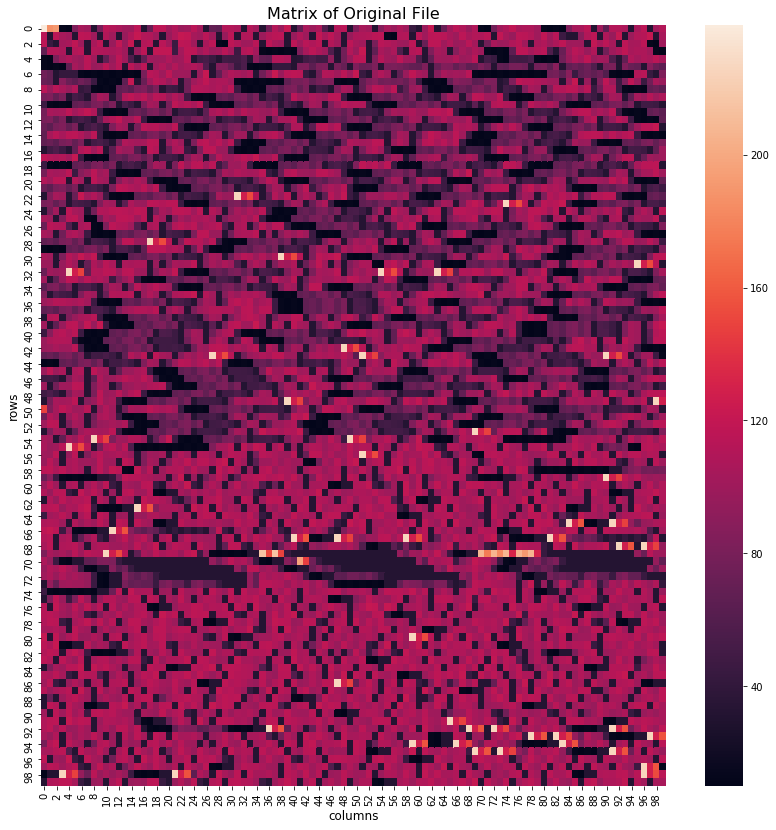

In [31]:
# Create and plot original matrix
row_len = 100
col_len = 100
ori_matrix = create_byte_matrix(text_byte_list, row_len, col_len)
plot_byte_matrix(ori_matrix, 'Matrix of Original File')

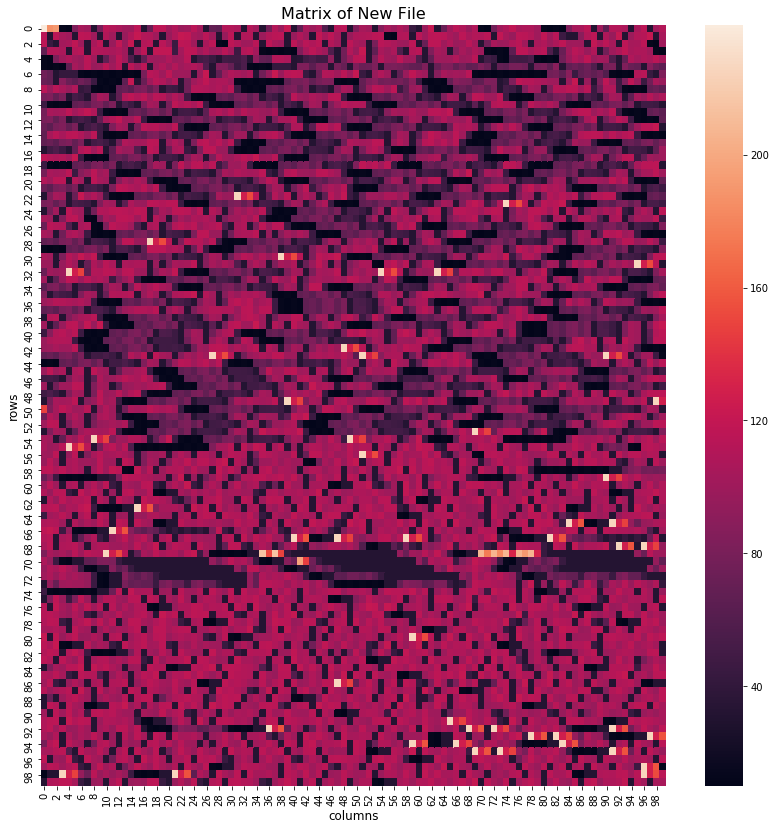

In [32]:
# Create and plot the new matrix (with low entropy)
row_len = 100
col_len = 100
ori_matrix = create_byte_matrix(best_byte_list, row_len, col_len)
plot_byte_matrix(ori_matrix, 'Matrix of New File')

In [33]:
# Save the new file as txt
temp_file_path = file_path.replace('.txt', '-new.txt')
with open(temp_file_path, 'w+b') as f:
    binary_format = bytearray(best_byte_list)
    f.write(binary_format)

### Theoretical compression percentage

In [34]:
# Calculating new theoretical compression percentage
compress_rate = calc_compression_percentage(actual_entropy, best_option['entropy'])
print(compress_rate, '%')

0.0 %


## 3. Restoring Entropy to Decompression

Below, the process to reverse the entropy of file to the initial value.

In [35]:
# Call the entropy restoration function
rule = best_option['key']
new_byte_list = restore_entropy(best_byte_list, rule, r)

#### Validation

In [36]:
# Comparing size of byte lists
len(text_byte_list) == len(new_byte_list)

True

In [37]:
# Comparing values of byte lists
sum(text_byte_list) - sum(new_byte_list)

0

In [38]:
# Comparing entropies of byte lists
entropy_shannon(text_byte_list, 2) == entropy_shannon(new_byte_list, 2)

True

#### Plotting

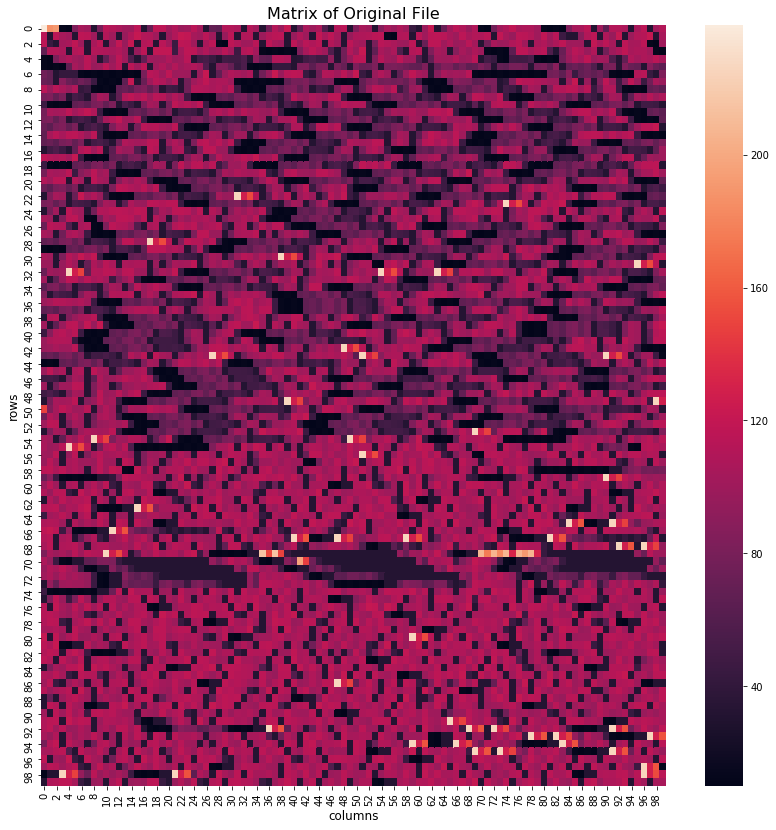

In [39]:
# Create and plot the new matrix (with low entropy)
row_len = 100
col_len = 100
ori_matrix = create_byte_matrix(new_byte_list, row_len, col_len)
plot_byte_matrix(ori_matrix, 'Matrix of Original File')

In [40]:
# Save the original file as txt
temp_file_path = file_path.replace('.txt', '-original.txt')
with open(temp_file_path, 'w+b') as f:
    binary_format = bytearray(new_byte_list)
    f.write(binary_format)

## References

<a name='link_one' href='https://en.wikipedia.org/wiki/Data_compression' target='_blank' >[1]</a> Wikipedia - Data Compression.  
<a name='link_two' href='https://en.wikipedia.org/wiki/Entropy' target='_blank' >[2]</a> Wikipedia - Entropy.  
<a name='link_three' href='https://en.wikipedia.org/wiki/Cellular_automaton' target='_blank' >[3]</a> Wikipedia - Cellular Automaton.  
<a name='link_four' href='https://ansegura7.github.io/Algorithms/cellular-automata/CellularAutomata.html' target='_blank' >[4]</a> Github - Algorithms.  

<hr>
<p><a href="https://ansegura7.github.io/DataCompression/">« Home</a></p>